In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../fem')
from heatconduction2d import main, postprocessdata, datasetgenerator
from randompolynomials import *

sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from VarMiON import VarMiON

In [3]:
simparams = {'inputdata': 'poly',
             'nelems': 32,
             'etype': 'square',
             'btype': 'spline',
             'basisdegree': 1,
             'intdegree': 2,
             'nfemsamples': 2}

trainingdataparams = {'N_sensornodes': 144,
                      'N_outputnodes': 100,
                      'N_sims': 3}

params = {}
params['simparams'] = simparams
params['trainingdataparams'] = trainingdataparams

c_theta = np.random.uniform(-0.1, 0.1, 10)
c_f = np.random.uniform(-0.1, 0.1, 10)
c_etab = np.random.uniform(-0.1, 0.1, 4)
c_etat = np.random.uniform(-0.1, 0.1, 4)

theta = randompoly2DO3sqr(c_theta)
f = randompoly2DO3sqr(c_f)
etab = randompoly1DO3(c_etab)
etat = randompoly1DO3(c_etat)
gl = 0
gr = 0

inputs = {'theta': theta,
          'f': f,
          'etab': etab,
          'etat': etat,
          'gl': gl,
          'gr': gr}

outputs = main(params, inputs, save=False, savedir='../../../trainingdata', label='test')

# generatedataset(params, save=True, savedir='../../../trainingdata', label='test')

optimize > constrained 66/1089 dofs
optimize > optimum value 0.00e+00
solve > solving 1023 dof system to machine precision using arnoldi solver
solve > solver returned with residual 2e-16


In [11]:
model = VarMiON
label = '5000epochs'
logdir = '../../../nnlogs'
sublogdir = 'best'
map_location = 'cpu'
model = loadmodelfromlabel(model, label, logdir, sublogdir, map_location)

data_postprocessed = postprocessdata(params, inputs, outputs)
Theta = data_postprocessed['Theta']
F = data_postprocessed['F']
N = data_postprocessed['N']
x = data_postprocessed['x']
u = data_postprocessed['u']

(4096,)


/tmp/ipykernel_877287/1120388204.py:50: RuntimeWarning: divide by zero encountered in divide
  fig = ax.tripcolor(x[:,0], x[:,1], np.abs((u_hat - u)/u), norm=matplotlib.colors.LogNorm())


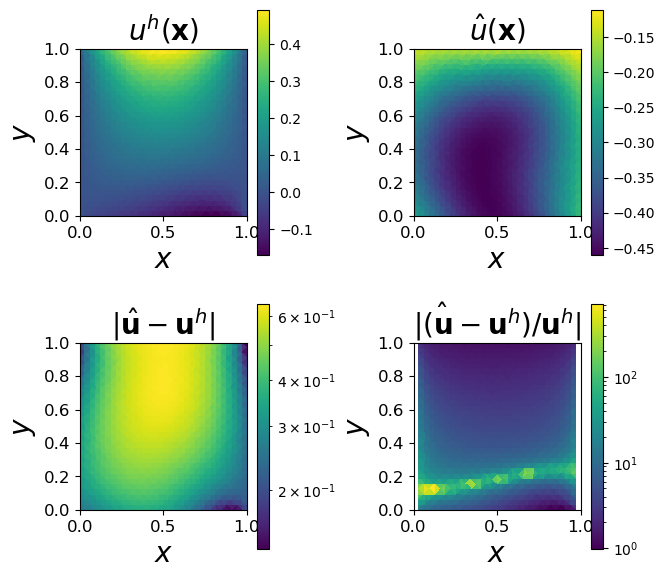

In [35]:
x = outputs['x']
u = outputs['u']
u_hat = model.simforward(Theta, F, N, x)
print(u.shape)

#plot
fig, axs = plt.subplots(2,2, figsize=(7, 7))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.2)
size_title = 20
size_ticklabels = 12
size_axeslabels = 20

ax = axs[0,0]
fig = ax.tripcolor(x[:,0], x[:,1], u)
ax.set_title(r"$u^h(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[0,1]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat)
ax.set_title(r"$\hat{u}(\mathbf{x})$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1,0]
fig = ax.tripcolor(x[:,0], x[:,1], np.abs(u_hat - u), norm=matplotlib.colors.LogNorm())
ax.set_title(r"$|\hat{\mathbf{u}} - \mathbf{u}^h|$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)

ax = axs[1,1]
fig = ax.tripcolor(x[:,0], x[:,1], np.abs((u_hat - u)/u), norm=matplotlib.colors.LogNorm())
ax.set_title(r"$|\hat{(\mathbf{u}} - \mathbf{u}^h)/\mathbf{u}^h|$", fontsize=size_title)
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
plt.colorbar(fig)